In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.svm import SVC, OneClassSVM
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.pipeline import Pipeline
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from mpl_toolkits.mplot3d import Axes3D #, axes3d

In [2]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [3]:
class Nested_cv:
    def __init__(self, n_outer_folds = 3, n_inner_folds = 3, n_top =1, state = 42):
        self.n_outer_folds = n_outer_folds
        self.n_inner_folds = n_inner_folds
        self.n_top = n_top
        self.state = state
#         print("constructor %d" %self.state)
                                        
    def set_pipe(self, pip_steps, pip_params):
        n_steps = len(pip_steps)
        if n_steps == 3:
            self.pipe = make_pipe(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2])
            self.params = pip_params
        if n_steps == 4:
            self.pipe = make_pipe_clf(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2], clf = pip_steps[3])
            self.params = pip_params
        else:
            print ("Number of steps gotta be either 3 or 4, you inserted %d." %n_steps)
        return self.pipe
        
    def fit(self, x_tot, y_tot, verbose = 0):
        self.verbose = verbose
#         print("fit %d" %self.state)
        if self.n_top >1 :
            print ("ACHTUNG! You need to use fit2 for multiple best models!")
            self.fit2(x_tot,y_tot)
        else:
            self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
            self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
            self.grid = GridSearchCV(self.pipe, self.params, cv = self.inner_cv, verbose = self.verbose)       
            self.score = cross_val_score(self.grid, X = x_tot, y = y_tot, cv = self.outer_cv, verbose = self.verbose)

    def get_outer_scores(self):
        return self.score
    
    def get_mean_score(self):
        self.mean_score = self.score.mean()
        print ("Mean score of %d outer folds : %f" %(self.n_outer_folds, self.mean_score ))
        return self.mean_score
    
    def combinations(self):
        self.comb = 1
        for self.key in self.params.keys():
            self.comb =self.comb*len(self.params[self.key])
        return self.comb
    
    def get_feat_scores(self):
        return self.total_feats
    
    def get_best_features(self):
        print(self.best_feat_ind)
        return self.best_feat_ind
    
    def print_feat_scores(self):
        self.norm_total_feats = (self.total_feats)/(self.n_inner_folds * self.n_top)
        plt.figure()
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_total_feats)
        plt.xlabel("Features")
        plt.ylabel("Score")
        plt.show()
        
    
    def repeated_cv(self,x_tot, y_tot, num_trials):
        self.repeated = np.zeros(num_trials)
        self.rep_feat_scores = np.zeros(x_tot.shape[1])
        self.num_trials = num_trials
        self.state +=1
        for st in range(self.num_trials):
            self.state +=1
            self.fit(x_tot, y_tot)
#             print("repeated %d" %self.state)
            self.out = self.get_outer_scores()
            self.rep_feat_scores += self.get_feat_scores()
            self.repeated[st] = self.out.mean()
            
        plt.figure()
        self.rep_sc_plot = plt.bar(range(num_trials),self.repeated)
        plt.xlabel("Individual trial #")
        plt.ylabel("Outer mean scores")
        plt.show()
    
    def print_rep_feat_scores(self):
        plt.figure()
        self.norm_rep_feats = (self.rep_feat_scores)/(self.n_inner_folds*self.n_top*self.num_trials)
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_rep_feats)
        plt.xlabel("Features")
        plt.ylabel("Feature Score")
        plt.show()
        
    def get_rep_feat_scores(self):
        return self.rep_feat_scores
        
    def fit2(self,x_tot, y_tot):
        #the "handwritten" implementation
        self.total_feats = np.zeros(x_tot.shape[1])
        self.classifiers= list(ParameterGrid(self.params))
        self.outer_scores = np.zeros((self.n_top, self.n_outer_folds))
#         self.ncomp = self.params['decomp__n_components']
#         self.best_feat_ind = []
        self.best_pipes = [[],[]]
        self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
        self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
        self.outer = self.outer_cv.split(x_tot,y_tot)
        for self.fold_out, (self.train_ind_out,self.test_ind_out) in enumerate(self.outer):
            top_models = []
            if self.verbose>0 :
                print("Outer loop %d/%d" %((self.fold_out + 1), self.n_outer_folds))
        # split the dataset 
            self.x_trn_out, self.x_tst_out = x_tot[self.train_ind_out], x_tot[self.test_ind_out]
            self.y_trn_out, self.y_tst_out = y_tot[self.train_ind_out], y_tot[self.test_ind_out]  
            
            self.inner_scores = np.zeros((len(self.classifiers),self.n_inner_folds))
            self.inner_mean_scores = np.zeros(len(self.classifiers))
            
            for self.cl_ind, self.clf in enumerate(self.classifiers):
                self.inner = self.inner_cv.split(self.x_trn_out, self.y_trn_out)
                self.nfeat = self.classifiers[self.cl_ind]['feature_selection__k']
                self.best_feat_ind = np.zeros((self.n_top, self.nfeat))


                for self.fold_in, (self.train_ind_in, self.test_ind_in) in enumerate(self.inner): 
                    if self.verbose>0 :
                        print("Inner fold %d/%d" % ((self.fold_in + 1), self.n_inner_folds ))
                    # split the datasets for the inner cv 
                    self.x_trn_in, self.x_tst_in = self.x_trn_out[self.train_ind_in], self.x_trn_out[self.test_ind_in]
                    self.y_trn_in, self.y_tst_in = self.y_trn_out[self.train_ind_in], self.y_trn_out[self.test_ind_in]
                    self.pip = self.pipe.set_params(**self.clf)
                    self.pip.fit(self.x_trn_in,self.y_trn_in)
                    self.inner_scores[self.cl_ind][self.fold_in] = self.pip.score(self.x_tst_in, self.y_tst_in)

            # get the mean performance for every classifier
            self.inner_mean_scores = np.mean(self.inner_scores, axis = 1)
#             print('\n',self.inner_mean_scores)

            # sort the scores, low -> high 
            self.sorted_inds = self.inner_mean_scores.argsort()
            self.sorted_scores = self.inner_mean_scores[self.sorted_inds]

            print ("Best %d models for outer fold %d are: \n " %(self.n_top, (self.fold_out+1)))

#             get the inds of best performing models
            self.temp2 = 0 #iterates over n_top models
            for self.temp_ind in range(-1, -(self.n_top +1), -1):
                self.actual_ind = self.sorted_inds[self.temp_ind]
                self.best_pipes[1].append(self.classifiers[self.actual_ind]) 
                self.best_pipes[0].append(self.fold_out)
                print("model no.%d "%(self.actual_ind + 1))
                print(self.classifiers[self.actual_ind])
                #print the top features selected
                self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
#                 best_fs = pipeline[actual_ind].named_steps['feature_selection']
                self.best_fs_indd = self.best_fs.get_support(indices = True)
#                 print(self.best_fs_indd)
                self.pipe_fs_unsorted = self.best_fs.scores_
                self.fs_inds = self.pipe_fs_unsorted.argsort()
#                 print(self.fs_inds)
                self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
                self.temp3 = 0 # temp3 = 0:number of features
               
                for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
                    self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
                    self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
                    self.temp3+=1
#                 print(self.total_feats)
                #fit the best classifier on the outer test data
                self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])
                
                self.best_pip.fit(self.x_trn_out, self.y_trn_out)
                
                #get the outer score 
                self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
                print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
                print ("----------------------------------------------------------")
                self.temp2+=1


#             print("Features selected: \n")
        #     print(best_feat_ind.sort())     
#             print(self.best_feat_ind)
        # print(outer_scores)  
        # print(best_pipes)
        self.score = self.outer_scores        

In [4]:
#================================================
#==================  EXAMPLE ====================
#================================================

In [2]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("sonar.csv",header = None)
dataset = df.values
Xsonar = dataset[:, 0:60].astype(float)
Ysonar = dataset[:,60]
#change the string output to int 
encoder = LabelEncoder()
encoder.fit(Ysonar)
ysonar = encoder.transform(Ysonar)

ImportError: No module named pandas

In [6]:
nest = Nested_cv(n_outer_folds= 5, n_inner_folds =5, n_top=2, state = 2)
steps = [StandardScaler(), SelectKBest(), PCA(), SVC()]
params = {'feature_selection__k' : [2], 'decomp__n_components':[2], 'classifier__kernel' : ['rbf'], 'classifier__C': [1,1000], 'classifier__gamma': [0.1,5]}
nest.set_pipe(pip_params= params, pip_steps=steps)
nest.fit(Xsonar,Ysonar)


ACHTUNG! You need to use fit2 for multiple best models!
Best 2 models for outer fold 1 are: 
 
model no.3 
{'decomp__n_components': 2, 'feature_selection__k': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__C': 1000}
[10 11]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Inner score: 0.721936 VS Outer score: 0.790698 

----------------------------------------------------------
model no.1 
{'decomp__n_components': 2, 'feature_selection__k': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__C': 1}
[10 11]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Inne

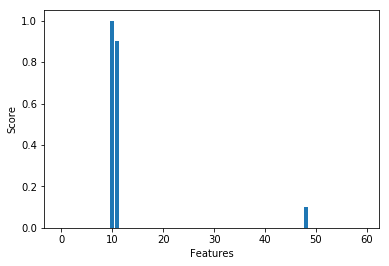

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   9.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [7]:
sx = nest.print_feat_scores()
print(nest.get_feat_scores())

ACHTUNG! You need to use fit2 for multiple best models!
Best 2 models for outer fold 1 are: 
 
model no.3 
{'decomp__n_components': 2, 'feature_selection__k': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__C': 1000}
[10 44]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Inner score: 0.715285 VS Outer score: 0.790698 

----------------------------------------------------------
model no.1 
{'decomp__n_components': 2, 'feature_selection__k': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__C': 1}
[10 11]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Inne

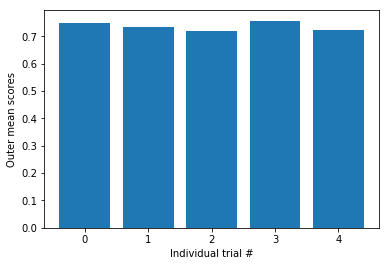

In [8]:
nest.repeated_cv(num_trials=5,x_tot=Xsonar,y_tot=Ysonar)

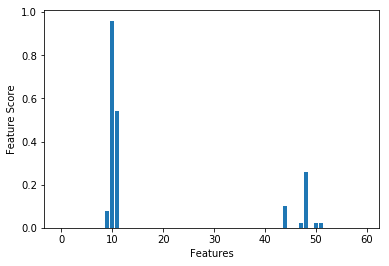

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   4.  48.  27.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5.
   0.   0.   1.  13.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.]


In [9]:
nest.print_rep_feat_scores()
print(nest.get_rep_feat_scores())

In [4]:
datapath = 'data/'
XYfile = datapath + 'newfeatures_1024_1_10_10000_XY.npz'
# Xpcafile = datapath + 'newfeatures_1024_1_10_10000_dimred.npz'
# Xtestsds = datapath + 'newfeatures_1024_1_10_10000_testds.npz'
XYfile2 = datapath + 'newfeatures_1024_1_10_20000_XY.npz'
############# GATHERING into one complete array
#X = np.load(XYfile)['X']
# with np.load(XYfile, encoding = 'latin1') as inpf:
#     X = inpf['X']
#     Y = inpf['Y']
with np.load(XYfile2, encoding = 'latin1') as inpf:
    X = inpf['X']
    Y = inpf['Y']

print ('gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2]))

gathered features:  (19782, 6216) (19782,) (20057, 6216) (20057,) (19874, 6216) (19874,) 8845.0


In [69]:
x2 = np.copy(X[2])
y2 = np.copy(Y[2])
x2 = x2[0: :10] ; y2 = y2[0: :10]
x2 = np.delete(x2,[8,534,1046,1050,3116,3642,4154,4158],1)
# print(x2.shape)
# nest2 = Nested_cv(n_outer_folds= 5, n_inner_folds =5, n_top=3, state = 2)
# steps2 = [StandardScaler(), SelectKBest(), PCA(), SVC()]
# params2 = {'feature_selection__k' : [750,950], 'decomp__n_components':[50,100], 'classifier__kernel' : ['rbf'], 'classifier__C': [1,100], 'classifier__gamma': ['auto']}
# nest2.set_pipe(pip_params= params2, pip_steps=steps2)
# nest2.fit(x2,y2)

(1000, 6216)


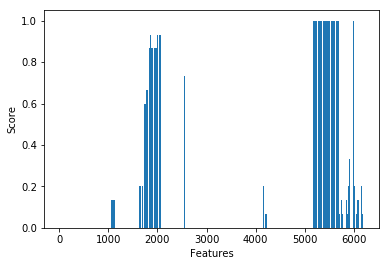

[  0.   0.   0. ...,   2.   1.  15.]


In [15]:
nest2.print_feat_scores()
# best_features = nest.get_best_features()
print(nest2.get_feat_scores())

In [89]:
x_test = np.copy(X[0]); y_test = np.copy(Y[0])
x_test = x_test[0::10] ; y_test = y_test[0: :10]
x_test = np.delete(x_test,[8,534,1046,1050,3116,3642,4154,4158],1)
# stepst = [StandardScaler(), SelectKBest(), PCA(), SVC()]
paramst = {'feature_selection__k' : 750, 'decomp__n_components': 50, 'classifier__kernel' : 'rbf', 'classifier__gamma': 'auto', 'classifier__C':47 }
test_pip = make_pipe_clf(feature_selection= SelectKBest(), clf= SVC(),decomp= PCA(), scaler= StandardScaler())

test_pip.set_params(**paramst)
test_pip.fit(x2,y2)
# test_pip.score(x_test,y_test)
cm = confusion_matrix(y_pred=test_pip.predict(x_test), y_true=y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm)


[[ 0.98094374  0.01905626]
 [ 0.54522613  0.45477387]]


In [91]:
temp_pip = make_pipe(feature_selection=SelectKBest(), decomp = PCA(), scaler = StandardScaler(), order = 1)
temp_params =  {'feature_selection__k' : 750, 'decomp__n_components': 50 }
temp_pip.set_params(**temp_params)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=750, score_func=<function f_classif at 0x00000059D9064730>)), ('decomp', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [107]:
xtemp1 = np.delete(X[0],[8,534,1046,1050,3116,3642,4154,4158],1)

xtemp = temp_pip.fit_transform(xtemp1,Y[0])


In [121]:
xnew = np.copy(xtemp)
xn = np.concatenate((xnew[:-3,:],xnew[1:-2,:],xnew[2:-1,:],xnew[3:,:]),axis = 1)

In [123]:
# print(xnew[1:-2,:].shape,xnew[:-3,:].shape,xnew[2:-1,:].shape,xnew[3:,:].shape)
# xn.shape
clfS = SVC(kernel='rbf', C =1)
clfS.fit(xn, Y[0][3:])


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
xtemp2 = np.delete(X[1],[8,534,1046,1050,3116,3642,4154,4158],1)
print(xtemp2.shape,xtemp.shape)
# xtemp = temp_pip.fit_transform(xtemp1,Y[0])

In [127]:
xtest = np.copy(X[1])
ytest = np.copy(Y[1])
xt = temp_pip.transform(xtest)
xt = np.concatenate((xt[:-3,:],xt[1:-2,:],xt[2:-1,:],xt[3:,:]),axis = 1)


ValueError: operands could not be broadcast together with shapes (20057,6216) (6208,) (20057,6216) 

In [3]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
Y = iris.target

In [6]:
from sklearn.feature_selection import RFECV
# xtest = np.copy(X[2]) ; ytest = np.copy(Y[2])
# xtest = xtest [0::10] ; ytest = ytest[0::10]
xtest = np.copy(X) ; ytest = np.copy(Y)
est = SVC(kernel = 'linear', C = 10)
selec = RFECV(est, step = 1, cv = StratifiedKFold(n_splits=5,random_state=42), verbose = 10000)
x_scaled = StandardScaler().fit_transform(xtest)
selec = selec.fit(x_scaled, ytest)
print(selec.n_features_)

Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
4
